
## Web scraping and analysis


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [2]:
from concurrent.futures import ThreadPoolExecutor

base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 36
page_size = 100

def scrape_page(page_number):
    print(f"Scraping page {page_number}")
    url = f"{base_url}/page/{page_number}/?sortby=post_date%3ADesc&pagesize={page_size}"
    response = requests.get(url)
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    page_reviews = [para.get_text() for para in parsed_content.find_all("div", {"class": "text_content"})]
    print(f"   ---> {len(page_reviews)} reviews on page {page_number}")
    return page_reviews

reviews = []
with ThreadPoolExecutor() as executor:
    for page_reviews in executor.map(scrape_page, range(1, pages + 1)):
        reviews.extend(page_reviews)

print(f"{len(reviews)} total reviews")


Scraping page 1
Scraping page 2Scraping page 3

Scraping page 4
Scraping page 5
Scraping page 6
   ---> 100 reviews on page 1
Scraping page 7
   ---> 100 reviews on page 2
Scraping page 8
   ---> 100 reviews on page 3
Scraping page 9
   ---> 100 reviews on page 5
Scraping page 10
   ---> 100 reviews on page 4
Scraping page 11
   ---> 100 reviews on page 6
Scraping page 12
   ---> 100 reviews on page 7
Scraping page 13
   ---> 100 reviews on page 8
Scraping page 14
   ---> 100 reviews on page 11   ---> 100 reviews on page 10
Scraping page 15

Scraping page 16
   ---> 100 reviews on page 9
Scraping page 17
   ---> 100 reviews on page 12
Scraping page 18
   ---> 100 reviews on page 13
Scraping page 19
   ---> 100 reviews on page 14
Scraping page 20
   ---> 100 reviews on page 17
Scraping page 21
   ---> 100 reviews on page 15
Scraping page 22
   ---> 100 reviews on page 18
Scraping page 23
   ---> 100 reviews on page 16
Scraping page 24
   ---> 100 reviews on page 19
Scraping page 25
   -

In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Easy check in a T5. Galleri...
1,"Not Verified | Flight delayed by an hour, it ..."
2,Not Verified | The staff are very rude and not...
3,✅ Trip Verified | Good domestic flight operat...
4,Not Verified | Failed at all basic travel fund...


In [4]:
import os

output_dir = 'data'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

output_path = os.path.join(output_dir, 'BA_reviews.csv')
df.to_csv(output_path)


Data cleaning

In [5]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def clean_text(text):
    text = re.sub(r'(✅ Trip Verified \|)|(Not Verified \|)', '', str(text))
    text = re.sub(r'\W', ' ', text)
    text = text.lower()
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

df['reviews'] = df['reviews'].apply(clean_text)
print(df.head())



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                             reviews
0  easy check t5 galleries south north lounges pa...
1  flight delayed hour happens biggie us change g...
2  staff rude trained properly exceptions made ch...
3  good domestic flight operated ba cityflyer gro...
4  failed basic travel fundamentals 1 flight dela...


In [6]:
from textblob import TextBlob

sentiments = df['reviews'].apply(lambda review: TextBlob(review).sentiment.polarity)


Sentiment analysis

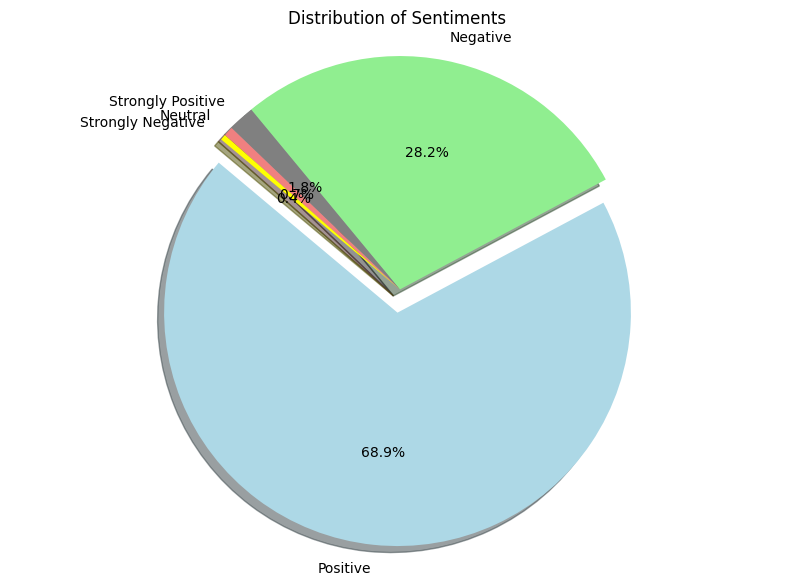

In [7]:
import matplotlib.pyplot as plt
from textblob import TextBlob

# Calculate sentiment for each review
df['sentiment'] = df['reviews'].apply(lambda review: TextBlob(review).sentiment.polarity)

def verbalize_sentiment(sentiment_score):
    if sentiment_score > 0.5:
        return "Strongly Positive"
    elif sentiment_score > 0:
        return "Positive"
    elif sentiment_score == 0:
        return "Neutral"
    elif sentiment_score > -0.5:
        return "Negative"
    else:
        return "Strongly Negative"

# Verbalize each sentiment
df['verbal_sentiment'] = df['sentiment'].apply(verbalize_sentiment)

# Count each sentiment type
sentiment_counts = df['verbal_sentiment'].value_counts()

# Create pie chart
colors = ['lightblue', 'lightgreen', 'grey', 'lightcoral', 'yellow']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice for emphasis
plt.figure(figsize=(10,7))
plt.pie(sentiment_counts, explode=explode, labels=sentiment_counts.index, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Sentiments')
plt.axis('equal')
plt.show()


most commun words

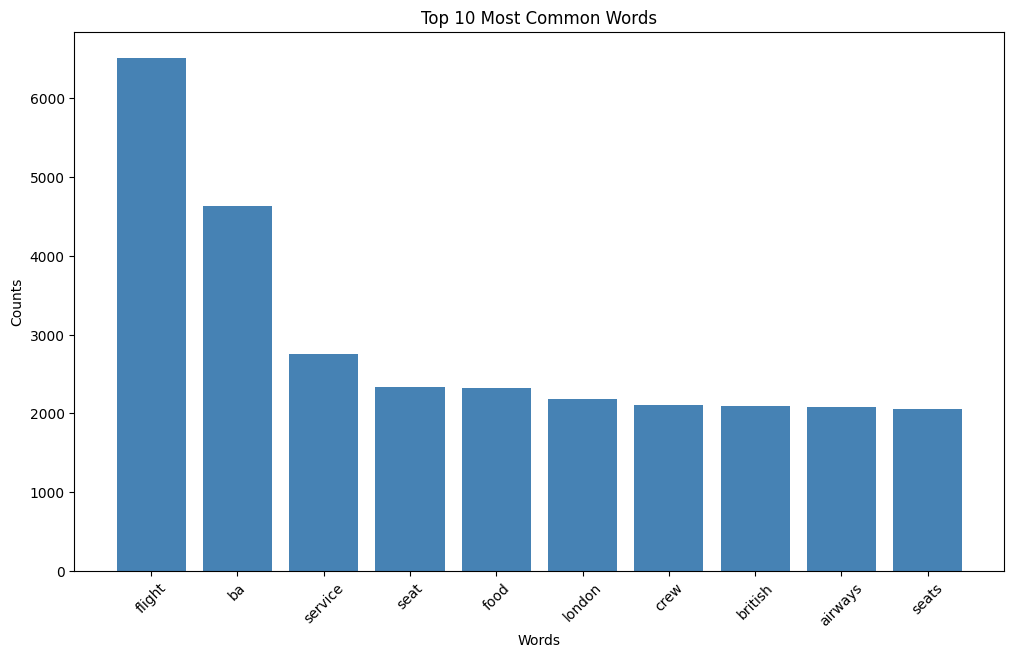

In [15]:
import matplotlib.pyplot as plt
from collections import Counter

# Split the reviews into words
words = ' '.join(df['reviews']).split()

# Get the frequency of each word
word_freq = Counter(words)

# Most common 10 words
most_common_words = word_freq.most_common(10)
words, counts = zip(*most_common_words)  # this separates the tuple into two lists: words and their counts

# Create a bar chart
plt.figure(figsize=(12, 7))
plt.bar(words, counts, color='steelblue')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Top 10 Most Common Words')
plt.xticks(rotation=45)  # rotating x-axis labels for better readability
plt.show()


most commun 2 consecutive words

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(df['reviews'])

# Sum the counts for each bigram
bigram_freq = X.sum(axis=0)
bigram_freq = [(word, bigram_freq[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)

print("Most common bigrams:", bigram_freq[:10])


Most common bigrams: [('british airways', 2009), ('business class', 1067), ('cabin crew', 844), ('verified review', 770), ('london heathrow', 670), ('customer service', 388), ('premium economy', 377), ('club world', 376), ('first class', 320), ('club europe', 298)]


topic modeling

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 1. Data Preprocessing
vectorizer = CountVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['reviews'])

# 2. LDA Model Training
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)

# 3. Display Topics
for index, topic in enumerate(lda_model.components_):
    print(f"Top 10 words for Topic #{index}")
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]])


Top 10 words for Topic #0
['airways', 'british', 'food', 'economy', 'flight', 'business', 'seats', 'class', 'seat', 'ba']
Top 10 words for Topic #1
['london', 'time', 'passengers', 'meal', 'food', 'cabin', 'ba', 'crew', 'service', 'flight']
Top 10 words for Topic #2
['hours', 'would', 'told', 'check', 'us', 'british', 'airways', 'london', 'ba', 'flight']
Top 10 words for Topic #3
['child', 'moscow', 'kids', 'daughter', 'would', 'cabin', 'british', 'airways', 'crew', 'baby']
Top 10 words for Topic #4
['lounge', 'lhr', 'service', 'cabin', 'time', 'food', 'ba', 'crew', 'good', 'flight']


### Topic #0: Flight Operations and Services
- **Keywords:** Flights, service, return, lounge, boarding, BA, check, crew, time, flight

### Topic #1: In-Flight Amenities and Comfort
- **Keywords:** Class, seats, service, crew, cabin, good, seat, food, BA, flight

### Topic #2: Overall Brand Perception
- **Keywords:** Get, would, customer, London, airline, service, airways, British, flight, BA

### Topic #3: Specific Locations and Routes
- **Keywords:** Reducing, mayonnaise, onwards, Hamburg, world, und, wir, Muscat, Abu, Dhabi

### Topic #4: Airport and Post-Flight Experience
- **Keywords:** Time, airport, luggage, staff, hours, London, us, check, BA, flight

word cloud

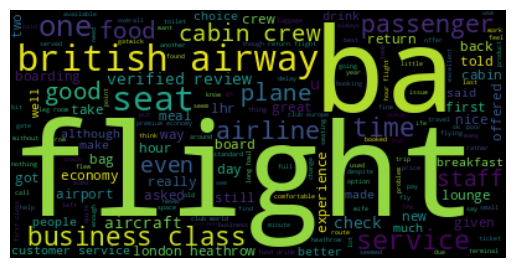

In [13]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud().generate(' '.join(df['reviews']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()



## Conclusion

---

**Most Common Bigrams**:
1. **British Airways (2009 mentions)**
    - Reflects the airline being the primary focus of the reviews.
2. **Business Class (1069 mentions)**
    - Highlights a frequent service class that many users had opinions about.
3. **Cabin Crew (840 mentions)**
    - Indicates the importance of the crew's role in passenger experience.
4. **London Heathrow (670 mentions)**
    - A major hub for British Airways and a common point of experience for many passengers.

---

**Most Common Words**:
1. **Flight (6527 mentions)**
    - Core component of travel; frequently discussed.
2. **BA (British Airways) (4624 mentions)**
    - Again, the airline itself is the main topic of conversation.
3. **Service (2762 mentions)**
    - Central to the traveler's experience.
4. **Seat (2345 mentions)**
    - Comfort and space might be significant concerns.
5. **Food (2316 mentions)**
    - In-flight meals are a point of contention or discussion for many.

---

**Overall Insights**:
1. **Prominent Role of British Airways**: The frequency of the term "British Airways" and its abbreviation "BA" reiterate the brand's prominence in the dataset.
2. **Travel Comfort is Key**: The frequent mentions of "business class," "seat," and "food" indicate that passengers value their in-flight comfort.
3. **Service is Central**: Both the "service" and "cabin crew" being frequently mentioned underscores the significance of in-flight service quality in influencing passenger reviews.